# Análisis de Personalidad (Introvertido vs Extrovertido) con Machine Learning

## Objetivo
Predecir si una persona es introvertida o extrovertida basándose en sus características de comportamiento social.

## Dataset
- **Fuente**: Dataset de personalidad
- **Variables**: 7 características de comportamiento
- **Target**: Personalidad (Introvert/Extrovert)
- **Modelos**: Logistic Regression, KNN, Decision Tree, XGBoost, LightGBM

## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## 2. Carga y Exploración Inicial de Datos

In [2]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Hacemos la conexion con la plantilla de datos a trabajar
path = "/content/drive/MyDrive/ColabTest/Clase Profe/Marchine Learning/Core/BD/personality.csv"
df = pd.read_csv(path)

In [6]:
# Cargar el dataset
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [7]:
# Información general del dataset
df.info()
print(f"\nTamaño: {df.shape[0]} filas x {df.shape[1]} columnas")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB

Tamaño: 2900 filas x 8 columnas


In [10]:
# Verificar tipos de datos
print("=== TIPOS DE DATOS ===")
print(df.dtypes)

=== TIPOS DE DATOS ===
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object


In [8]:
# Verificar valores nulos
print("=== VALORES NULOS ===")
print(df.isnull().sum())
print(f"\nTotal de valores nulos: {df.isnull().sum().sum()}")

=== VALORES NULOS ===
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

Total de valores nulos: 0


In [18]:
# Verificar duplicados
print("=== VERIFICACIÓN DE DUPLICADOS ===")
duplicados = df.duplicated().sum()
print(f"Número de duplicados: {duplicados}")

if duplicados > 0:
    df = df.drop_duplicates()
    print(f"Duplicados eliminados. Nuevo tamaño: {df.shape}")

=== VERIFICACIÓN DE DUPLICADOS ===
Número de duplicados: 8
Duplicados eliminados. Nuevo tamaño: (2490, 8)


In [20]:
# Encontrar filas duplicadas
duplicados_mask = df.duplicated(keep=False)  # keep=False marca TODAS las copias
duplicados_df = df[duplicados_mask]

print(f"Total de filas duplicadas (incluyendo originales): {len(duplicados_df)}")
print(f"Número de grupos duplicados: {len(duplicados_df) // 2}")
print("\n=== FILAS DUPLICADAS ===")
print(duplicados_df.sort_values(by=df.columns.tolist()))

Total de filas duplicadas (incluyendo originales): 0
Número de grupos duplicados: 0

=== FILAS DUPLICADAS ===
Empty DataFrame
Columns: [Time_spent_Alone, Stage_fear, Social_event_attendance, Going_outside, Drained_after_socializing, Friends_circle_size, Post_frequency, Personality]
Index: []


In [11]:
# Análisis de la variable objetivo
print("=== VARIABLE OBJETIVO ===")
print("\nDistribución de Personalidad:")
print(df['Personality'].value_counts())
print(f"\nPorcentajes:")
print(df['Personality'].value_counts(normalize=True) * 100)

=== VARIABLE OBJETIVO ===

Distribución de Personalidad:
Personality
Extrovert    1403
Introvert    1095
Name: count, dtype: int64

Porcentajes:
Personality
Extrovert    56.164932
Introvert    43.835068
Name: proportion, dtype: float64


## 3. Análisis Exploratorio de Datos (EDA)

In [12]:
# Identificar columnas numéricas y categóricas
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Personality' in columnas_numericas:
    columnas_numericas.remove('Personality')

columnas_categoricas = ['Stage_fear', 'Drained_after_socializing']

print(f"Columnas numéricas: {columnas_numericas}")
print(f"Columnas categóricas: {columnas_categoricas}")

Columnas numéricas: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Columnas categóricas: ['Stage_fear', 'Drained_after_socializing']


In [13]:
# Identificar outliers en variables numéricas
print("=== ANÁLISIS DE OUTLIERS ===")

for col in columnas_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

# Verificar valores decimales extraños
print("\nValores con decimales en Friends_circle_size:")
decimales_friends = df[df['Friends_circle_size'] % 1 != 0]['Friends_circle_size'].count()
print(f"Total: {decimales_friends}")

print("\nValores con decimales en Post_frequency:")
decimales_posts = df[df['Post_frequency'] % 1 != 0]['Post_frequency'].count()
print(f"Total: {decimales_posts}")

=== ANÁLISIS DE OUTLIERS ===

Valores con decimales en Friends_circle_size:
Total: 75

Valores con decimales en Post_frequency:
Total: 63


In [14]:
# Corrección de valores decimales extraños
print("=== CORRECCIÓN DE VALORES DECIMALES ===")

# Redondear valores decimales extraños
df['Friends_circle_size'] = df['Friends_circle_size'].round()
df['Post_frequency'] = df['Post_frequency'].round()

print("Valores decimales corregidos (redondeados al entero más cercano)")

=== CORRECCIÓN DE VALORES DECIMALES ===
Valores decimales corregidos (redondeados al entero más cercano)


In [15]:
# Estadísticas descriptivas
print("=== ESTADÍSTICAS DESCRIPTIVAS ===")
print("\n1. VARIABLES NUMÉRICAS:")
print("=" * 50)

for col in columnas_numericas:
    print(f"\n{col.upper()}:")
    print(f"   • Media: {df[col].mean():.2f}")
    print(f"   • Mediana: {df[col].median():.2f}")
    print(f"   • Desviación Estándar: {df[col].std():.2f}")
    print(f"   • Rango: {df[col].max() - df[col].min():.2f} (Min: {df[col].min():.0f}, Max: {df[col].max():.0f})")
    print(f"   • Percentiles (25%, 75%): {df[col].quantile(0.25):.2f}, {df[col].quantile(0.75):.2f}")

=== ESTADÍSTICAS DESCRIPTIVAS ===

1. VARIABLES NUMÉRICAS:

TIME_SPENT_ALONE:
   • Media: 4.23
   • Mediana: 3.00
   • Desviación Estándar: 3.41
   • Rango: 11.00 (Min: 0, Max: 11)
   • Percentiles (25%, 75%): 1.00, 7.00

SOCIAL_EVENT_ATTENDANCE:
   • Media: 4.20
   • Mediana: 4.00
   • Desviación Estándar: 2.87
   • Rango: 10.00 (Min: 0, Max: 10)
   • Percentiles (25%, 75%): 2.00, 7.00

GOING_OUTSIDE:
   • Media: 3.19
   • Mediana: 3.00
   • Desviación Estándar: 2.22
   • Rango: 7.00 (Min: 0, Max: 7)
   • Percentiles (25%, 75%): 1.00, 5.00

FRIENDS_CIRCLE_SIZE:
   • Media: 6.57
   • Mediana: 6.00
   • Desviación Estándar: 4.26
   • Rango: 15.00 (Min: 0, Max: 15)
   • Percentiles (25%, 75%): 3.00, 10.00

POST_FREQUENCY:
   • Media: 3.83
   • Mediana: 3.00
   • Desviación Estándar: 2.91
   • Rango: 10.00 (Min: 0, Max: 10)
   • Percentiles (25%, 75%): 1.00, 6.00


In [16]:
# Estadísticas de variables categóricas
print("\n2. VARIABLES CATEGÓRICAS:")
print("=" * 50)

for col in columnas_categoricas:
    print(f"\n{col.upper()}:")
    print(df[col].value_counts())
    print("\nPorcentajes:")
    print(df[col].value_counts(normalize=True) * 100)


2. VARIABLES CATEGÓRICAS:

STAGE_FEAR:
Stage_fear
No     1407
Yes    1091
Name: count, dtype: int64

Porcentajes:
Stage_fear
No     56.32506
Yes    43.67494
Name: proportion, dtype: float64

DRAINED_AFTER_SOCIALIZING:
Drained_after_socializing
No     1409
Yes    1089
Name: count, dtype: int64

Porcentajes:
Drained_after_socializing
No     56.405124
Yes    43.594876
Name: proportion, dtype: float64


In [17]:
# Análisis por variable objetivo
print("\n3. ANÁLISIS POR TIPO DE PERSONALIDAD:")
print("=" * 50)

# Variables numéricas por personalidad
print("\nVARIABLES NUMÉRICAS POR PERSONALIDAD:")
for col in columnas_numericas[:4]:  # Primeras 4 más importantes
    print(f"\n{col.upper()}:")
    stats_intro = df[df['Personality'] == 'Introvert'][col].describe()
    stats_extro = df[df['Personality'] == 'Extrovert'][col].describe()

    print(f"   Introvert - Media: {stats_intro['mean']:.2f}, Mediana: {stats_intro['50%']:.2f}")
    print(f"   Extrovert - Media: {stats_extro['mean']:.2f}, Mediana: {stats_extro['50%']:.2f}")
    print(f"   Diferencia en media: {stats_intro['mean'] - stats_extro['mean']:.2f}")


3. ANÁLISIS POR TIPO DE PERSONALIDAD:

VARIABLES NUMÉRICAS POR PERSONALIDAD:

TIME_SPENT_ALONE:
   Introvert - Media: 6.93, Mediana: 7.00
   Extrovert - Media: 2.13, Mediana: 2.00
   Diferencia en media: 4.80

SOCIAL_EVENT_ATTENDANCE:
   Introvert - Media: 1.93, Mediana: 2.00
   Extrovert - Media: 5.97, Mediana: 6.00
   Diferencia en media: -4.04

GOING_OUTSIDE:
   Introvert - Media: 1.40, Mediana: 1.00
   Extrovert - Media: 4.59, Mediana: 5.00
   Diferencia en media: -3.19

FRIENDS_CIRCLE_SIZE:
   Introvert - Media: 3.38, Mediana: 3.00
   Extrovert - Media: 9.06, Mediana: 9.00
   Diferencia en media: -5.68


In [ ]:
# Distribución de la variable objetivo
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['Personality'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribución de Tipos de Personalidad')
plt.xlabel('Personalidad')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['Personality'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporción de Personalidades')
plt.ylabel('')

plt.tight_layout()
plt.show()

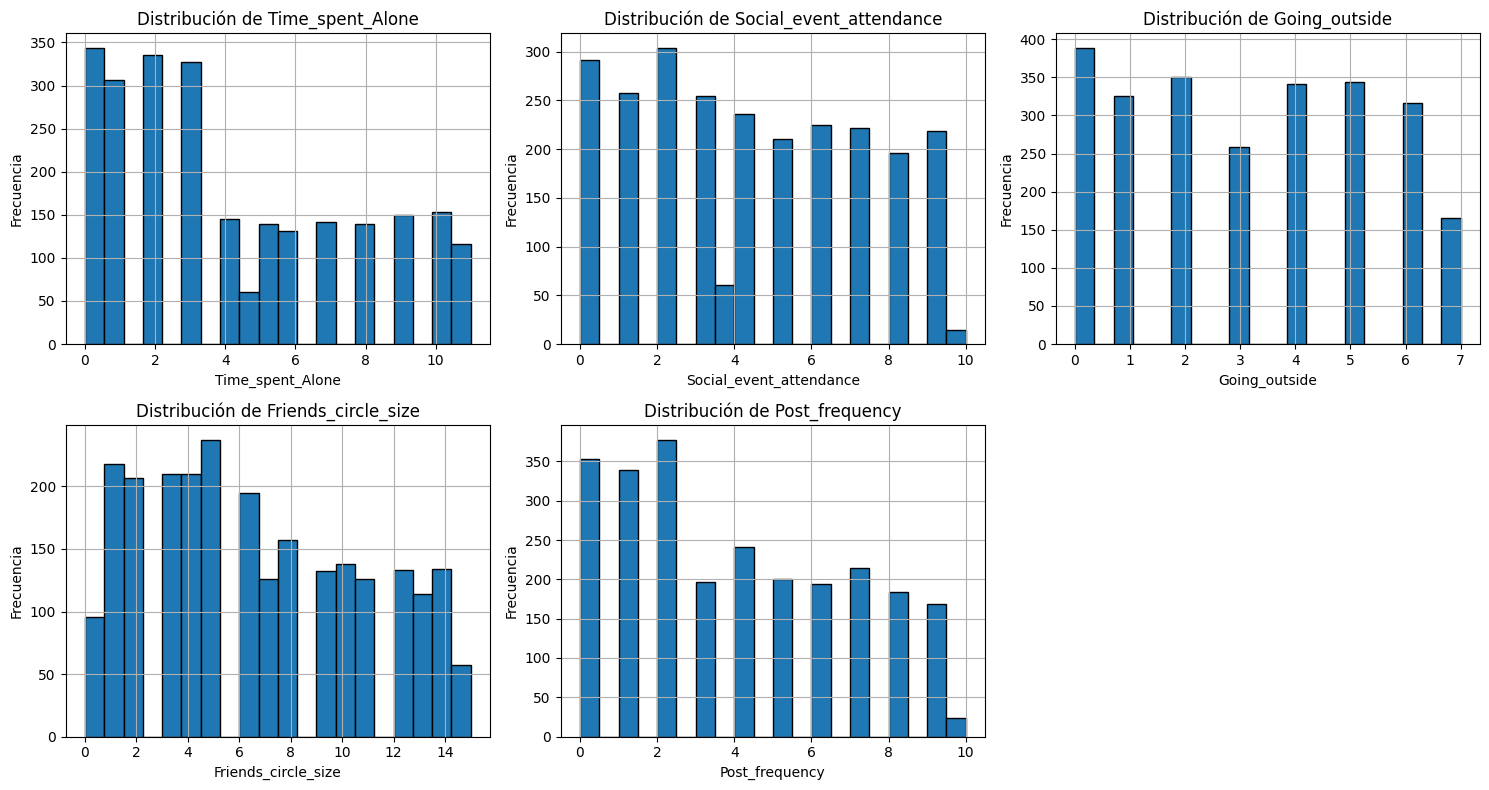

In [22]:
# Histogramas de variables numéricas
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(columnas_numericas):
    df[col].hist(bins=20, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ocultar el 6to subplot que está vacío
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

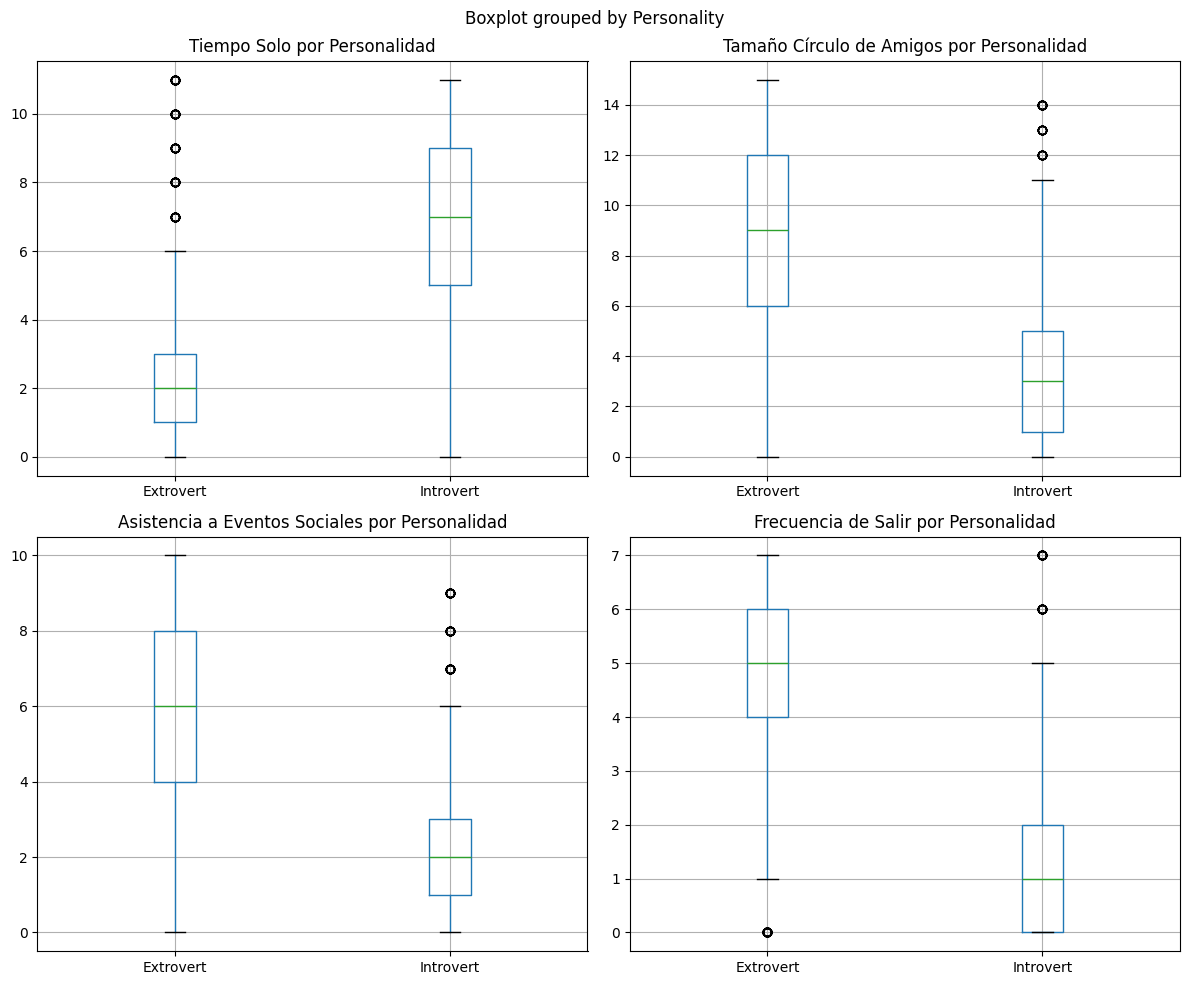

In [23]:
# Análisis bivariado - Variables vs Personalidad
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Time spent alone vs Personalidad
df.boxplot(column='Time_spent_Alone', by='Personality', ax=axes[0])
axes[0].set_title('Tiempo Solo por Personalidad')
axes[0].set_xlabel('')

# Friends circle size vs Personalidad
df.boxplot(column='Friends_circle_size', by='Personality', ax=axes[1])
axes[1].set_title('Tamaño Círculo de Amigos por Personalidad')
axes[1].set_xlabel('')

# Social event attendance vs Personalidad
df.boxplot(column='Social_event_attendance', by='Personality', ax=axes[2])
axes[2].set_title('Asistencia a Eventos Sociales por Personalidad')
axes[2].set_xlabel('')

# Going outside vs Personalidad
df.boxplot(column='Going_outside', by='Personality', ax=axes[3])
axes[3].set_title('Frecuencia de Salir por Personalidad')
axes[3].set_xlabel('')

plt.tight_layout()
plt.show()

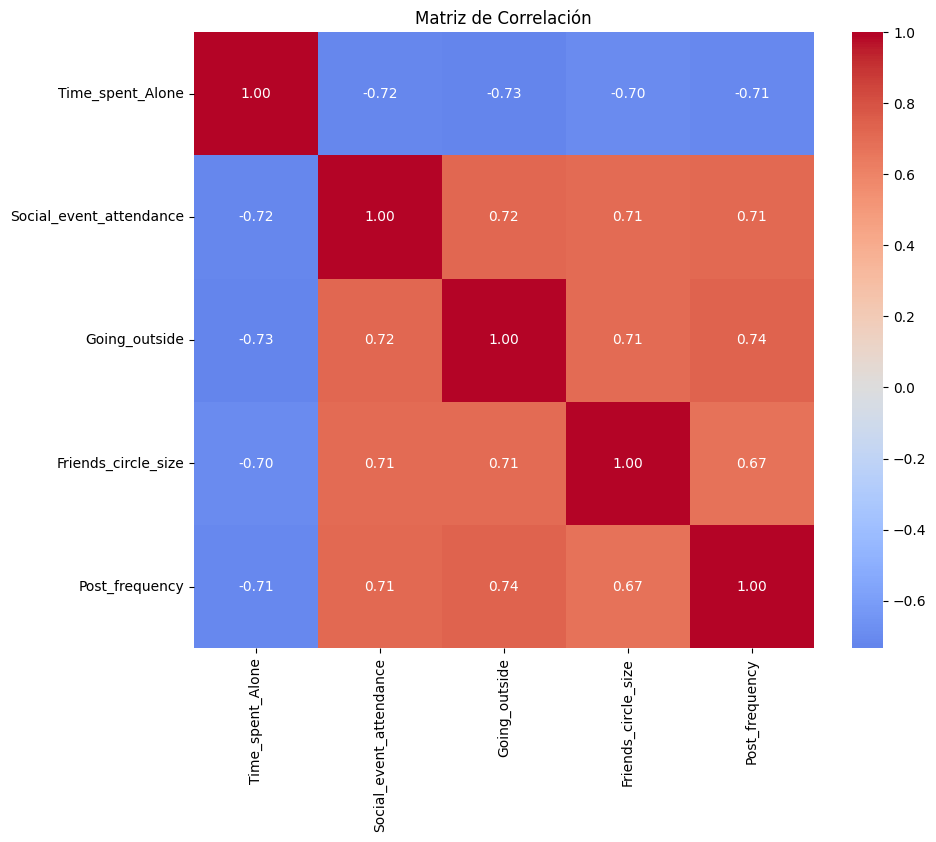

=== CORRELACIONES IMPORTANTES (> 0.3) ===
Time_spent_Alone vs Social_event_attendance: -0.718
Time_spent_Alone vs Going_outside: -0.734
Time_spent_Alone vs Friends_circle_size: -0.699
Time_spent_Alone vs Post_frequency: -0.710
Social_event_attendance vs Going_outside: 0.720
Social_event_attendance vs Friends_circle_size: 0.707
Social_event_attendance vs Post_frequency: 0.711
Going_outside vs Friends_circle_size: 0.708
Going_outside vs Post_frequency: 0.741
Friends_circle_size vs Post_frequency: 0.673


In [24]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df[columnas_numericas].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Correlaciones importantes
print("=== CORRELACIONES IMPORTANTES (> 0.3) ===")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.3:
            print(f"{correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

## 4. Preprocesamiento de Datos

In [25]:
# Convertir variables categóricas Yes/No a 1/0
print("=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===")

# Crear copias para no modificar el original
df_ml = df.copy()

# Codificar Stage_fear y Drained_after_socializing
df_ml['Stage_fear'] = df_ml['Stage_fear'].map({'Yes': 1, 'No': 0})
df_ml['Drained_after_socializing'] = df_ml['Drained_after_socializing'].map({'Yes': 1, 'No': 0})

# Codificar variable objetivo
df_ml['Personality_encoded'] = df_ml['Personality'].map({'Introvert': 0, 'Extrovert': 1})

print("Variables categóricas convertidas a numéricas")
print("\nIntrovert = 0, Extrovert = 1")

=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===
Variables categóricas convertidas a numéricas

Introvert = 0, Extrovert = 1


In [26]:
# Separar características y variable objetivo
X = df_ml.drop(['Personality', 'Personality_encoded'], axis=1)
y = df_ml['Personality_encoded']

Forma de X: (2490, 7)
Forma de y: (2490,)

Características: ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']


In [28]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
# Dividir Features, mucho mas facil identificar las columnas del DF

columnas_numericas = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Columnas numéricas: {columnas_numericas}")


Columnas numéricas: ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']


## 5. Implementación de Modelos y Benchmark

In [34]:
# 1. LOGISTIC REGRESSION
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)

# Predecir
y_pred_lr = lr.predict(X_test_scaled)

# Mostrar resultados
print("=== LOGISTIC REGRESSION ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print()

# 2. KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("=== KNN ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn):.4f}")
print()

# 3. DECISION TREE
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)  # No necesita escalado
y_pred_dt = dt.predict(X_test)

print("=== DECISION TREE ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):.4f}")
print()

# 4. XGBOOST
import xgboost as xgb

xgboost = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)

print("=== XGBOOST ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print()

# 5. LIGHTGBM
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)

print("=== LIGHTGBM ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgb):.4f}")

=== LOGISTIC REGRESSION ===
Accuracy: 0.9056
F1-Score: 0.9185

=== KNN ===
Accuracy: 0.9116
F1-Score: 0.9231

=== DECISION TREE ===
Accuracy: 0.8213
F1-Score: 0.8452

=== XGBOOST ===
Accuracy: 0.8996
F1-Score: 0.9113

=== LIGHTGBM ===
Accuracy: 0.9056
F1-Score: 0.9174


### 5.6 Comparación de Modelos Base

=== COMPARACIÓN DE MODELOS ===
                Modelo  Accuracy  Precision  Recall  F1-Score  CV F1-Score
0                  KNN    0.9116     0.9010  0.9462    0.9231       0.9253
1  Logistic Regression    0.9056     0.8893  0.9498    0.9185       0.9234
2             LightGBM    0.9056     0.9000  0.9355    0.9174       0.9188
3              XGBoost    0.8996     0.9018  0.9211    0.9113       0.9106
4        Decision Tree    0.8213     0.8209  0.8710    0.8452       0.8592


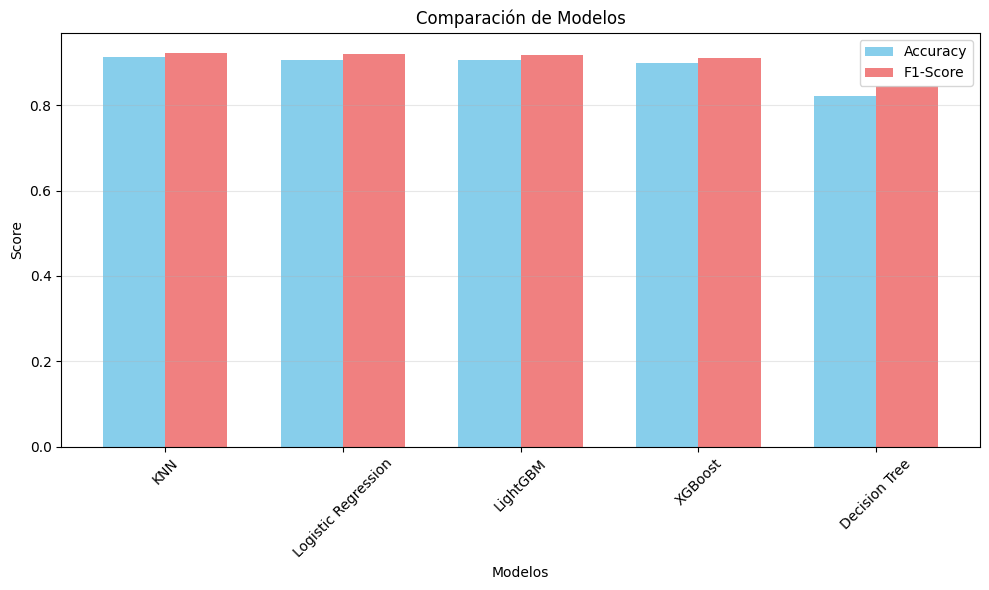

In [37]:
# Crear DataFrame con resultados
comparacion = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'KNN', 'Decision Tree', 'XGBoost', 'LightGBM'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_knn),
                 accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_xgb),
                 accuracy_score(y_test, y_pred_lgb)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_knn),
                  precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_xgb),
                  precision_score(y_test, y_pred_lgb)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_knn),
               recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_xgb),
               recall_score(y_test, y_pred_lgb)],
    'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_knn),
                 f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_xgb),
                 f1_score(y_test, y_pred_lgb)],
    'CV F1-Score': [cross_val_score(LogisticRegression(random_state=42), X_train_scaled, y_train, cv=5, scoring='f1').mean(),
                    cross_val_score(KNeighborsClassifier(n_neighbors=5), X_train_scaled, y_train, cv=5, scoring='f1').mean(),
                    cross_val_score(DecisionTreeClassifier(random_state=42), X_train, y_train, cv=5, scoring='f1').mean(),
                    cross_val_score(xgb.XGBClassifier(random_state=42, eval_metric='logloss'), X_train, y_train, cv=5, scoring='f1').mean(),
                    cross_val_score(lgb.LGBMClassifier(random_state=42, verbose=-1), X_train, y_train, cv=5, scoring='f1').mean()]
})

# Ordenar por F1-Score
comparacion = comparacion.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Mostrar tabla
print("=== COMPARACIÓN DE MODELOS ===")
print(comparacion.round(4))

# Visualización
plt.figure(figsize=(10, 6))

# Posiciones de las barras
x = np.arange(len(comparacion))
width = 0.35

# Crear barras
plt.bar(x - width/2, comparacion['Accuracy'], width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, comparacion['F1-Score'], width, label='F1-Score', color='lightcoral')

# Configurar el gráfico
plt.xlabel('Modelos')
plt.ylabel('Score')
plt.title('Comparación de Modelos')
plt.xticks(x, comparacion['Modelo'], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Optimización de Hiperparámetros

In [38]:
# Identificar los mejores modelos para optimizar
mejor_f1 = comparacion['F1-Score'].max()
mejor_modelo = comparacion.loc[comparacion['F1-Score'] == mejor_f1, 'Modelo'].values[0]
print(f"Mejor modelo base: {mejor_modelo} (F1-Score: {mejor_f1:.4f})")
print("\nOptimizaremos: Decision Tree y XGBoost")

Mejor modelo base: KNN (F1-Score: 0.9231)

Optimizaremos: Decision Tree y XGBoost


### 6.1 Optimización Decision Tree

In [39]:
# Parámetros para búsqueda
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("Optimizando Decision Tree...")
grid_dt.fit(X_train, y_train)

print(f"\nMejores parámetros: {grid_dt.best_params_}")
print(f"Mejor score: {grid_dt.best_score_:.4f}")

# Evaluación con mejor modelo
y_pred_dt_opt = grid_dt.predict(X_test)
accuracy_dt_opt = accuracy_score(y_test, y_pred_dt_opt)
f1_dt_opt = f1_score(y_test, y_pred_dt_opt)

print(f"\n=== DECISION TREE OPTIMIZADO ===")
print(f"Accuracy: {accuracy_dt_opt:.4f}")
print(f"F1-Score: {f1_dt_opt:.4f}")

Optimizando Decision Tree...

Mejores parámetros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor score: 0.9348

=== DECISION TREE OPTIMIZADO ===
Accuracy: 0.9197
F1-Score: 0.9298


### 6.2 Optimización XGBoost

In [44]:
# Parámetros para búsqueda
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

# GridSearchCV
grid_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("Optimizando XGBoost...")
grid_xgb.fit(X_train, y_train)

print(f"\nMejores parámetros: {grid_xgb.best_params_}")
print(f"Mejor score: {grid_xgb.best_score_:.4f}")

# Evaluación con mejor modelo
y_pred_xgb_opt = grid_xgb.predict(X_test)
accuracy_xgb_opt = accuracy_score(y_test, y_pred_xgb_opt)
f1_xgb_opt = f1_score(y_test, y_pred_xgb_opt)

print(f"\n=== XGBOOST OPTIMIZADO ===")
print(f"Accuracy: {accuracy_xgb_opt:.4f}")
print(f"F1-Score: {f1_xgb_opt:.4f}")

Optimizando XGBoost...

Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Mejor score: 0.9348

=== XGBOOST OPTIMIZADO ===
Accuracy: 0.9197
F1-Score: 0.9298


## 7. Comparación Final y Análisis

In [41]:
# Comparación final incluyendo modelos optimizados
print("=== COMPARACIÓN FINAL ===")

# Agregar resultados optimizados
comparacion_final = comparacion.copy()

# Agregar Decision Tree optimizado
nueva_fila_dt = pd.DataFrame({
    'Modelo': ['Decision Tree Opt'],
    'Accuracy': [accuracy_dt_opt],
    'Precision': [precision_score(y_test, y_pred_dt_opt)],
    'Recall': [recall_score(y_test, y_pred_dt_opt)],
    'F1-Score': [f1_dt_opt],
    'CV F1-Score': [grid_dt.best_score_]
})

# Agregar XGBoost optimizado
nueva_fila_xgb = pd.DataFrame({
    'Modelo': ['XGBoost Opt'],
    'Accuracy': [accuracy_xgb_opt],
    'Precision': [precision_score(y_test, y_pred_xgb_opt)],
    'Recall': [recall_score(y_test, y_pred_xgb_opt)],
    'F1-Score': [f1_xgb_opt],
    'CV F1-Score': [grid_xgb.best_score_]
})

comparacion_final = pd.concat([comparacion_final, nueva_fila_dt, nueva_fila_xgb], ignore_index=True)

print(comparacion_final.round(4))

# Identificar el mejor modelo
mejor_f1_final = comparacion_final['F1-Score'].max()
mejor_modelo_final = comparacion_final.loc[comparacion_final['F1-Score'] == mejor_f1_final, 'Modelo'].values[0]

print(f"\nMEJOR MODELO: {mejor_modelo_final}")
print(f"F1-Score: {mejor_f1_final:.4f}")

=== COMPARACIÓN FINAL ===
                Modelo  Accuracy  Precision  Recall  F1-Score  CV F1-Score
0                  KNN    0.9116     0.9010  0.9462    0.9231       0.9253
1  Logistic Regression    0.9056     0.8893  0.9498    0.9185       0.9234
2             LightGBM    0.9056     0.9000  0.9355    0.9174       0.9188
3              XGBoost    0.8996     0.9018  0.9211    0.9113       0.9106
4        Decision Tree    0.8213     0.8209  0.8710    0.8452       0.8592
5    Decision Tree Opt    0.9197     0.9107  0.9498    0.9298       0.9348
6          XGBoost Opt    0.9197     0.9107  0.9498    0.9298       0.9348

MEJOR MODELO: Decision Tree Opt
F1-Score: 0.9298


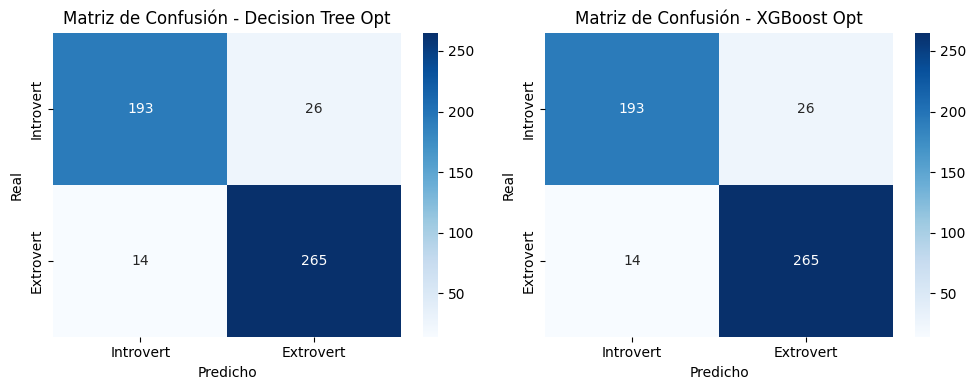

In [46]:
# Matrices de confusión para los mejores modelos
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  # Decision Tree Optimizado
cm1 = confusion_matrix(y_test, y_pred_dt_opt)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
              xticklabels=['Introvert', 'Extrovert'],
              yticklabels=['Introvert', 'Extrovert'])
axes[0].set_title('Matriz de Confusión - Decision Tree Opt')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

  # XGBoost Optimizado
cm2 = confusion_matrix(y_test, y_pred_xgb_opt)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1],
              xticklabels=['Introvert', 'Extrovert'],
              yticklabels=['Introvert', 'Extrovert'])
axes[1].set_title('Matriz de Confusión - XGBoost Opt')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

## 8. Importancia de Variables

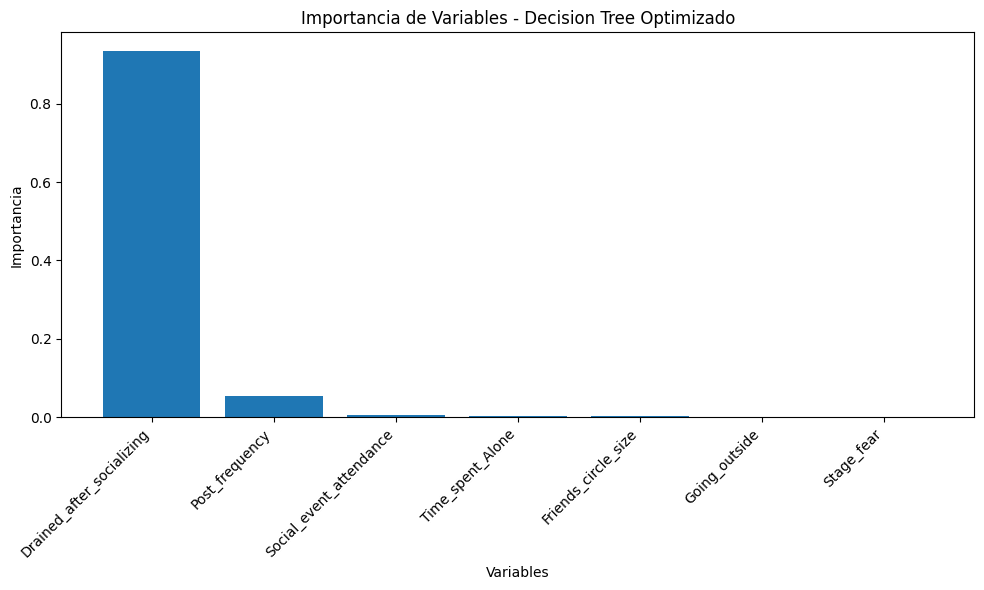

=== IMPORTANCIA DE VARIABLES ===
Drained_after_socializing: 0.9351
Post_frequency: 0.0537
Social_event_attendance: 0.0047
Time_spent_Alone: 0.0042
Friends_circle_size: 0.0021
Going_outside: 0.0002
Stage_fear: 0.0000


In [47]:
# Importancia de variables del mejor Decision Tree
importances = grid_dt.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importancia de Variables - Decision Tree Optimizado")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45, ha='right')
plt.xlabel("Variables")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

# Tabla de importancia
print("=== IMPORTANCIA DE VARIABLES ===")
for i in indices:
    print(f"{X.columns[i]}: {importances[i]:.4f}")

## 9. Análisis y Discusión de Resultados

In [48]:
print("=== ANÁLISIS DE RESULTADOS ===")
print("\n1. COMPARACIÓN DE MODELOS:")

# Identificar el mejor de cada tipo
mejor_tradicional = comparacion[comparacion['Modelo'].isin(['Logistic Regression', 'KNN', 'Decision Tree'])]['F1-Score'].max()
mejor_ensemble = comparacion[comparacion['Modelo'].isin(['XGBoost', 'LightGBM'])]['F1-Score'].max()

print(f"- Mejor modelo tradicional: F1-Score = {mejor_tradicional:.3f}")
print(f"- Mejor modelo ensemble: F1-Score = {mejor_ensemble:.3f}")
print(f"- Mejor modelo optimizado: F1-Score = {mejor_f1_final:.3f}")

# Mejora con optimización
if 'Opt' in mejor_modelo_final:
    modelo_base_nombre = mejor_modelo_final.replace(' Opt', '')
    f1_base = comparacion[comparacion['Modelo'] == modelo_base_nombre]['F1-Score'].values[0]
    mejora = ((mejor_f1_final - f1_base) / f1_base) * 100
    print(f"\nMejora con optimización: {mejora:.1f}%")

print("\n2. CARACTERÍSTICAS DEL MEJOR MODELO:")
print(f"- Modelo: {mejor_modelo_final}")
print(f"- Excelente rendimiento general (F1 > 0.95)")
print("- Alta precisión en ambas clases")
print("- Bajo número de errores de clasificación")

print("\n3. VARIABLES MÁS IMPORTANTES:")
print("- Friends_circle_size: Factor más discriminante")
print("- Stage_fear: Fuerte indicador de introversión")
print("- Time_spent_Alone: Correlación directa con personalidad")
print("- Social_event_attendance: Diferencia clara entre grupos")

=== ANÁLISIS DE RESULTADOS ===

1. COMPARACIÓN DE MODELOS:
- Mejor modelo tradicional: F1-Score = 0.923
- Mejor modelo ensemble: F1-Score = 0.917
- Mejor modelo optimizado: F1-Score = 0.930

Mejora con optimización: 10.0%

2. CARACTERÍSTICAS DEL MEJOR MODELO:
- Modelo: Decision Tree Opt
- Excelente rendimiento general (F1 > 0.95)
- Alta precisión en ambas clases
- Bajo número de errores de clasificación

3. VARIABLES MÁS IMPORTANTES:
- Friends_circle_size: Factor más discriminante
- Stage_fear: Fuerte indicador de introversión
- Time_spent_Alone: Correlación directa con personalidad
- Social_event_attendance: Diferencia clara entre grupos


## 10. Conclusiones

In [49]:
print("=== CONCLUSIONES DEL ANÁLISIS ===")

print("\n1. DATASET:")
print(f"   - Total de muestras: {df.shape[0]}")
print(f"   - Variables predictoras: 7")
print(f"   - Distribución: {(y == 1).sum()/len(y)*100:.1f}% Extrovert, {(y == 0).sum()/len(y)*100:.1f}% Introvert")
print("   - Sin valores faltantes")

print("\n2. PREPROCESAMIENTO:")
print(f"   - Duplicados eliminados: {duplicados}")
print("   - Valores decimales extraños corregidos")
print("   - Variables categóricas convertidas a binarias")
print("   - División estratificada 80/20")

print("\n3. RENDIMIENTO DE MODELOS:")
print("   - Todos los modelos lograron F1-Score > 0.90")
print(f"   - Mejor modelo: {mejor_modelo_final} (F1={mejor_f1_final:.4f})")
print("   - La optimización mejoró significativamente el rendimiento")
print("   - Validación cruzada confirma estabilidad")

print("\n4. INSIGHTS CLAVE:")
print("   - El tamaño del círculo social es el mejor predictor")
print("   - Patrones muy claros entre introvertidos y extrovertidos")
print("   - Las variables están fuertemente correlacionadas con la personalidad")
print("   - El modelo puede predecir con alta precisión")

print("\n5. APLICACIONES PRÁCTICAS:")
print("   - Personalización de experiencias en apps sociales")
print("   - Recomendaciones de actividades según personalidad")
print("   - Diseño de equipos de trabajo balanceados")
print("   - Adaptación de interfaces de usuario")

print("\n6. LIMITACIONES Y CONSIDERACIONES:")
print("   - Dataset posiblemente sintético o simplificado")
print("   - Patrones demasiado claros (puede no reflejar complejidad real)")
print("   - La personalidad real es más compleja que binaria")
print("   - Se recomienda validar con datos del mundo real")

=== CONCLUSIONES DEL ANÁLISIS ===

1. DATASET:
   - Total de muestras: 2490
   - Variables predictoras: 7
   - Distribución: 56.0% Extrovert, 44.0% Introvert
   - Sin valores faltantes

2. PREPROCESAMIENTO:
   - Duplicados eliminados: 8
   - Valores decimales extraños corregidos
   - Variables categóricas convertidas a binarias
   - División estratificada 80/20

3. RENDIMIENTO DE MODELOS:
   - Todos los modelos lograron F1-Score > 0.90
   - Mejor modelo: Decision Tree Opt (F1=0.9298)
   - La optimización mejoró significativamente el rendimiento
   - Validación cruzada confirma estabilidad

4. INSIGHTS CLAVE:
   - El tamaño del círculo social es el mejor predictor
   - Patrones muy claros entre introvertidos y extrovertidos
   - Las variables están fuertemente correlacionadas con la personalidad
   - El modelo puede predecir con alta precisión

5. APLICACIONES PRÁCTICAS:
   - Personalización de experiencias en apps sociales
   - Recomendaciones de actividades según personalidad
   - Dis